In [1]:
# pip install cleantext
from cleantext import clean

In [2]:
%%time

def clean_text(text):
    return clean(text,
                fix_unicode=True,               # fix various unicode errors
                to_ascii=True,                  # transliterate to closest ASCII representation
                lower=False,                     # lowercase text
                no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                no_urls=False,                  # replace all URLs with a special token
                no_emails=True,                # replace all email addresses with a special token
                no_phone_numbers=True,         # replace all phone numbers with a special token
                no_numbers=False,               # replace all numbers with a special token
                no_digits=False,                # replace all digits with a special token
                no_currency_symbols=False,      # replace all currency symbols with a special token
                no_punct=False,                 # fully remove punctuation
                replace_with_url="<URL>",
                replace_with_email="<EMAIL>",
                replace_with_phone_number="<PHONE>",
                replace_with_number="<NUMBER>",
                replace_with_digit="0",
                replace_with_currency_symbol="<CUR>",
                lang="en"                       # set to 'de' for German special handling
            )

Wall time: 0 ns


In [23]:
def reuters_news_wire_texts():
    from keras.datasets import reuters

    (x_train, y_train), (x_test, y_test) = reuters.load_data()
    wordDict = {y:x for x,y in reuters.get_word_index().items()}  
    texts = []
    for x in x_train:
        texts.append(" ".join([wordDict.get(index-3) for index in x if wordDict.get(index-3) is not None]))
    return texts, y_train


# Load 20 newsgroup dataset

Alternativ auch nochmal mit sample_5000 probieren.

In [2]:
# import pandas as pd
# from sklearn.datasets import fetch_20newsgroups
# newsgroups_train = fetch_20newsgroups(subset='train')
# newsgroups_test = fetch_20newsgroups(subset='test')
# print(pd.Series(newsgroups_train['data']).str.split().apply(len).quantile(0.9))

508.0


# Cleaning

In [56]:
from dlutils import dlutils
# _input = fetch_20newsgroups(subset='train')['data']
_input, y = reuters_news_wire_texts()
# %time _input = [clean_text(x) for x in _input]
vocab = np.unique([word for text in _input for word in text.split()])

# Encoding
### Use max_seq_len = 512 for encoding the texts and a smaller max_seq_len to encode the words

In [57]:
_input[10]

'period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

In [58]:
from bert_serving.client import BertClient
import numpy as np
bc = BertClient()


In [59]:
embeddings = bc.encode(_input)
np.save('data/embeddings.npy', embeddings)

C:\Users\Dlenz\Anaconda3\envs\py36\lib\site-packages\bert_serving\client\__init__.py:278: UserWarning: some of your sentences have more tokens than "max_seq_len=512" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [60]:
vocab_vecs = bc.encode(list(vocab))
np.save('data/vocab_vecs.npy', vocab_vecs)

# Word Vector Tests

compare different words for their similarity

In [61]:
import pandas as pd
import sklearn
vocabdf = pd.DataFrame(np.array(list(vocab)))
vocabdf['vecs'] = list(vocab_vecs)

word1, word2 = 'cat', 'dog'

k1 = vocabdf[vocabdf[0]==word1].vecs.values[0]
k2 = vocabdf[vocabdf[0]==word2].vecs.values[0]
print(k1.shape)
print(k2.shape)
sklearn.metrics.pairwise.cosine_similarity(k1.reshape(1,-1),k2.reshape(1,-1))

(768,)
(768,)


array([[0.958865]], dtype=float32)

Wall time: 2min 27s


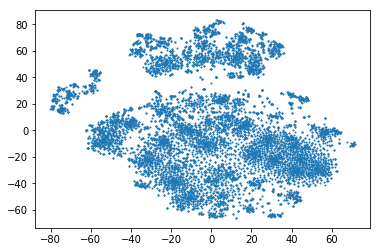

In [127]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne=TSNE()
%time d2vecs = tsne.fit_transform(np.vstack([embeddings, cluster_centers]))
plt.scatter(d2vecs[:embeddings.shape[0], 0], d2vecs[:embeddings.shape[0], 1], s=1)

# Clustering

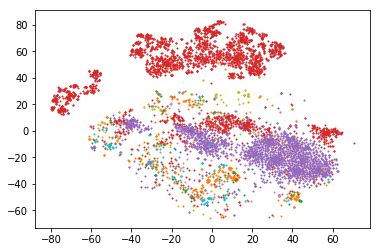

In [128]:
# reuters news wire clustering
for i in range(n_topics-36):
    indices = np.where(y==i)[0]
    vecs = d2vecs[indices]
    plt.scatter(vecs[:, 0], vecs[:, 1], s=1)
    

In [134]:
import numpy as np
from sklearn.mixture import GaussianMixture
n_topics = 46
gmm = GaussianMixture(n_components=n_topics, covariance_type='full')

%time gmm.fit(embeddings)
topic_assignment = gmm.predict(embeddings)

indices = np.where(topic_assignment==1)[0]
center = np.array(embeddings)[indices].mean(axis=0)

Wall time: 39.9 s


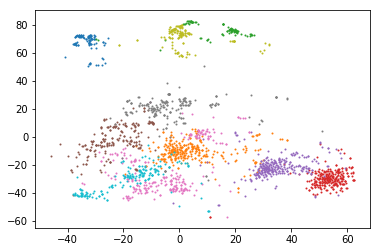

In [136]:
for i in range(n_topics-36):
    indices = np.where(topic_assignment==i)[0]
    vecs = d2vecs[indices]
    plt.scatter(vecs[:, 0], vecs[:, 1], s=1)
    

In [142]:
cluster_centers=list()
for i in range(n_topics):
   # print(i)
    indices = np.where(topic_assignment==i)[0]
    center = np.array(embeddings)[indices].mean(axis=0)
    cluster_centers.append(center)

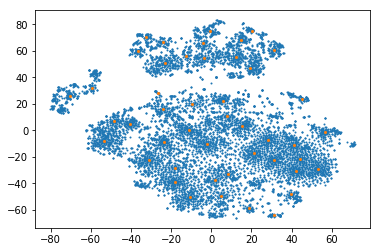

In [143]:
plt.scatter(d2vecs[:embeddings.shape[0], 0], d2vecs[:embeddings.shape[0], 1], s=1)
plt.scatter(d2vecs[embeddings.shape[0]:, 0], d2vecs[embeddings.shape[0]:, 1], s=4)

In [139]:
k=[]
for i, center in enumerate(cluster_centers):
    sim = sklearn.metrics.pairwise.cosine_similarity([center], vocab_vecs)
    k.append([i,sim])

In [92]:
%time adsf = pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(vocab_vecs))

In [118]:
adsf.iloc[18021].sort_values(ascending=False)
vocab[16814]

'mission'

In [70]:
# Choose topic number and number of words should be used for the word cloud 
topic_number= 7
words_topic=100
res_topic=[]
for res in results[topic_number]:
    res_topic.append(res)

d ={'word': list(vocab), 'cosine_sim': res_topic}
topic_df = pd.DataFrame(data=d)

topic_sorted = topic_df.sort_values(by=['cosine_sim'],ascending=False)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = topic_sorted['word'][0:words_topic].tolist()
text = ', '.join(text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

NameError: name 'results' is not defined

# LDA

In [144]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

tf =TfidfVectorizer()
lda = LatentDirichletAllocation(n_topics)

%time tfvecs = tf.fit_transform(_input)
%time lda_vecs = lda.fit_transform(tfvecs)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

n_top_words=10
print("\nTopics in LDA model:")
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Wall time: 715 ms
Wall time: 21.9 s

Topics in LDA model:
Topic #0: ccc taft bonus guarantees corporation credit commodity walker enhancement guarantee
Topic #1: slaughter ago pdvsa head starts units venezuela adjusted versus multi
Topic #2: guinness dibona 648 swire gte connecticut hecla sprint crime webb
Topic #3: coffee ico quotas ecuador colombia dauster santos fairchild venezuela westminster
Topic #4: supermarkets dart pl utilicorp saudis petrobras hudson atcor 062 789
Topic #5: hawley carter spectra physics valor 820 hale ciba geigy ortner
Topic #6: trade japanese tariffs yeutter gatt japan lyng the ec nakasone
Topic #7: 744 amstutz cenergy undersecretary catches bryson rent credited allocated myers
Topic #8: stg the bank mln of bills england fed market band
Topic #9: genova resorts interco lane bilzerian meat mechanically separated loom nwbl
Topic #10: petrol octane gm ultramar pump gelco ranchman lazere litre cray
Topic #11: 728 793 476 988 617 526 537 459 029 068
Topic #12: ir